# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [83]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [84]:
# ratings = pd.read_csv('music_dataset.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2024/homeworks/hw4_recsys/music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [85]:
# tracks_info = pd.read_csv('tracks_info.csv')
tracks_info = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2024/homeworks/hw4_recsys/tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [86]:
def apk(n_u: int, r_u: List[bool], k: int = 20):
    # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪
    ap_k = 0
    for i in range(k):
        ap_k += r_u[i] * r_u[:i+1].sum() / (i+1)
    return ap_k / min(k, n_u)


def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪
    map_k, n = 0, 0
    for true, pred in zip(relevant, predicted):
        k = min(k, len(pred))
        r_u = np.isin(pred[:k], true)
        map_k += apk(len(true), r_u, k)
        n += 1
    return map_k / n

In [87]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [88]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [89]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [90]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [91]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [92]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [93]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [94]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [95]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [96]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items), dtype=int)
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for user_id in np.unique(self.ratings['userId']):
            test_preds.append(self.recommend(user_id))
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [97]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪

    sums_r_with_u = (ratings&user_vector).sum(axis=1)
    sum_r_u = user_vector.sum()
    sums_r_other = ratings.sum(axis=1)

    return sums_r_with_u / (np.sqrt(sum_r_u) * np.sqrt(sums_r_other))


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪

    u_and_other = ratings&user_vector
    u_or_other = ratings|user_vector

    return u_and_other.sum(axis=1) / u_or_other.sum(axis=1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [98]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪

        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪

        similars = self.similarity(self.R[uid])
        similars[uid] = 0

        n_R_uid = self.R[similars > self.alpha]
        s_un = similars[similars > self.alpha].reshape(-1, 1)

        n_s_un_uid = n_R_uid * s_un

        pred_r_u = n_s_un_uid.sum(axis=0) / (s_un.sum() + np.finfo(s_un.dtype).eps)

        return np.argsort(-pred_r_u)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [ ]:
# (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪

In [99]:
class RandomModel(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        return np.random.permutation(self.n_items)

In [ ]:
model_random = RandomModel(train_ratings)
model_pearson = User2User(train_ratings, pearson)
model_jaccard = User2User(train_ratings, jaccard)

In [ ]:
ks = np.arange(1, 101)
preds_random = model_random.get_test_recommendations(ks[-1])
preds_pearson = model_pearson.get_test_recommendations(ks[-1])
preds_jaccard = model_jaccard.get_test_recommendations(ks[-1])

In [ ]:
mapk_random = [mapk(test_relevant, preds_random, k) for k in ks]
mapk_pearson = [mapk(test_relevant, preds_pearson, k) for k in ks]
mapk_jaccard = [mapk(test_relevant, preds_jaccard, k) for k in ks]

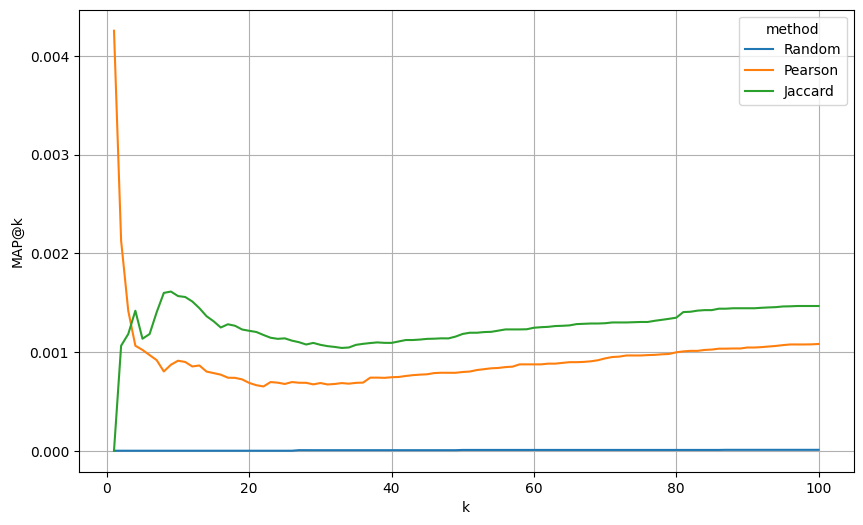

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ks, mapk_random, label='Random')
plt.plot(ks, mapk_pearson, label='Pearson')
plt.plot(ks, mapk_jaccard, label='Jaccard')

plt.legend(title='method')
plt.grid()
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.show()

***Сравнение***

* У рандома все плохо

* Пирсон хорошо рекомендует первые несколько треков, а дальше плохо

* Жаккар наоборот, плохо рекомендует первые несколько треков, а дальше лучше


**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# (your)my code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

In [100]:
class Sparse_BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = scs.coo_array((np.ones(len(self.ratings), dtype=int),
                               (self.ratings.userId, self.ratings.trackId)),
                               shape=(self.n_users, self.n_items)).tocsr()

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in np.unique(self.ratings['userId']):
            test_preds.append(self.recommend(user_id))
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

In [101]:
def sparse_pearson(ratings: np.array, user_vector: np.array) -> np.array:

    sums_r_with_u = (ratings*user_vector).sum(axis=1)
    sum_r_u = user_vector.sum()
    sums_r_other = ratings.sum(axis=1)

    return sums_r_with_u / (np.sqrt(sum_r_u) * np.sqrt(sums_r_other))


def sparse_jaccard(ratings: np.array, user_vector: np.array) -> np.array:

    u_and_other = ratings*user_vector
    u_or_other = ratings-u_and_other+user_vector.toarray().squeeze()

    return u_and_other.sum(axis=1) / u_or_other.sum(axis=1)

In [102]:
class Sparse_User2User(Sparse_BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [sparse_pearson, sparse_jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        similars = self.similarity(self.R[[uid]])
        similars[uid] = 0

        n_R_uid = self.R[similars > self.alpha]
        s_un = similars[similars > self.alpha].reshape(-1, 1)

        n_s_un_uid = n_R_uid * s_un

        pred_r_u = n_s_un_uid.sum(axis=0) / (s_un.sum() + np.finfo(s_un.dtype).eps)

        return np.argsort(-pred_r_u)

In [103]:
model_pearson = User2User(train_ratings, pearson)
model_jaccard = User2User(train_ratings, jaccard)

sparse_model_pearson = Sparse_User2User(train_ratings, sparse_pearson)
sparse_model_jaccard = Sparse_User2User(train_ratings, sparse_jaccard)

ks = np.arange(1, 101)

In [104]:
%%time
preds_pearson = model_pearson.get_test_recommendations(ks[-1])
preds_jaccard = model_jaccard.get_test_recommendations(ks[-1])

CPU times: user 35 s, sys: 21.5 s, total: 56.5 s
Wall time: 57.3 s


In [105]:
%%time
sparse_preds_pearson = sparse_model_pearson.get_test_recommendations(ks[-1])
sparse_preds_jaccard = sparse_model_jaccard.get_test_recommendations(ks[-1])

CPU times: user 9.83 s, sys: 6.18 s, total: 16 s
Wall time: 16 s


Ну стало значительно быстрее =)

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [106]:
model = sparse_model_jaccard

In [107]:
user_id = np.random.randint(0, model.n_users)

In [108]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
29,Hello,['Lionel Richie']
213,Cuidar Nuestro Amor,['David Bisbal']
362,Don't Let Me Be Misunderstood,['Nina Simone']
554,Feeling Good,['Nina Simone']
702,Ne Me Quitte Pas,['Nina Simone']
1627,Could I Have This Kiss Forever,"['Enrique Iglesias', 'Whitney Houston']"
2308,Goodbye My Lover,['James Blunt']
2841,It's a Man's Man's Man's World,['Seal']
2926,Feeling Good,['Michael Bublé']
2962,In This Shirt,['The Irrepressibles']


In [109]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
805,Zombie,['The Cranberries']
41078,Зелёные волны,['Zivert']
53422,Dance Monkey,['Tones And I']
24500,Way Down We Go,['KALEO']
52075,Kукушка,['Полина Гагарина']
46533,Life,['Zivert']
60765,Сияй,"[""Ramil'""]"
18070,Dernière danse,['Indila']
39265,Beggin',['Måneskin']
46279,"Мама, я танцую",['#2Маши']


In [110]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
64544,Rampampam,['Minelli']
64599,Obscura,"['Power-Haus', 'Christian Reindl']"
64670,Родной,['LOBODA']
64689,Sicko Drop,"['KVSH', 'Schillist']"
64735,Lie To Me,"['Demeter', 'Ticia']"
64801,Follow You,['Imagine Dragons']
65089,Я весь мир обошёл,['HammAli & Navai']
65114,The Magic Bomb,['Hoàng Read']
65269,Still in da Disco,"['Hedegaard', 'Maga']"
65368,XOXO,['Charlotte Cardin']


Как-то не очень...

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Мой Ответ

$$
e_{ui} = (r_{ui} - \hat{r}_{ui})
$$

$$
p_{u,k+1} = p_{u,k} + \eta (q_{i,k} \cdot e_{ui} - \lambda p_{u,k})
$$
$$
q_{i,k+1} = q_{i,k} + \eta (p_{u,k} \cdot e_{ui} - \lambda q_{i,k})
$$

\\
**ALS:**

Мой Ответ

$$
p_u = (\sum_{i : \exists r_{ui}} q_i q_i^T + \lambda I)^{-1} \sum_{i : \exists r_{ui}} r_{ui} q_i
$$

$$
q_i = (\sum_{u : \exists r_{ui}} p_u p_u^T + \lambda I)^{-1} \sum_{u : \exists r_{ui}} r_{ui} p_u
$$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [155]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # my(your) code here: (￣▽￣)/♫•*¨*•.¸¸♪

                u = np.random.randint(self.n_users)
                i = np.random.randint(self.n_items)
                e_ui = self.R[u, i] - self.P[u] @ self.Q[i]

                self.P[u] = self.P[u] + self.lr * (self.Q[i] * e_ui - self.lamb * self.P[u])
                self.Q[i] = self.Q[i] + self.lr * (self.P[u] * e_ui - self.lamb * self.Q[i])


            elif self.mode == 'als':
                # my(your) code here: (￣▽￣)/♫•*¨*•.¸¸♪

                I = np.eye(self.dim)
                RQ = self.R @ self.Q
                for u in range(self.n_users):
                    relevant_items = self.R[u] == 1
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.lamb * I) @ RQ[u]

                RP = self.R.T @ self.P
                for i in range(self.n_items):
                    relevant_users = self.R[:, i] == 1
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.lamb * I) @ RP[i]


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [156]:
class Sparse_HiddenVars(Sparse_BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # my(your) code here: (￣▽￣)/♫•*¨*•.¸¸♪

                u = np.random.randint(self.n_users)
                i = np.random.randint(self.n_items)
                e_ui = self.R[u, i] - self.P[u] @ self.Q[i]

                self.P[u] = self.P[u] + self.lr * (self.Q[i] * e_ui - self.lamb * self.P[u])
                self.Q[i] = self.Q[i] + self.lr * (self.P[u] * e_ui - self.lamb * self.Q[i])


            elif self.mode == 'als':
                # my(your) code here: (￣▽￣)/♫•*¨*•.¸¸♪

                I = np.eye(self.dim)
                RQ = self.R @ self.Q
                for u in range(self.n_users):
                    relevant_items = (self.R[[u]] == 1).toarray().squeeze()
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.lamb * I) @ RQ[u]

                RP = self.R.T @ self.P
                for i in range(self.n_items):
                    relevant_users = (self.R[:, [i]] == 1).toarray().squeeze()
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.lamb * I) @ RP[i]


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [160]:
# (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪
model = HiddenVars(train_ratings, mode='als')
model.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

In [148]:
# (your)my code here: (￣▽￣)/♫•*¨*•.¸¸♪
sparse_model = Sparse_HiddenVars(train_ratings, mode='als')
sparse_model.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [152]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [153]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.734307
5570,Моё сердце,['Сплин'],0.615633
16637,Zodiac,['Zodiac'],0.608684
5153,Stormbringer,['Deep Purple'],0.608684
9689,Bicycle Race,['Queen'],0.608684
16192,Однажды мир прогнётся под нас,['Машина времени'],0.595960
16224,Пока горит свеча,['Машина времени'],0.595196
58063,UNO,['Little Big'],0.577101
2179,Восьмиклассница,['КИНО'],0.573162
